# Baseline Model

## Introducción
En esta notebook se implementa un modelo base de regresion logistica que servirá como referencia para evaluar futuras mejoras. El modelo base nos permitirá establecer un punto de partida y medir la efectividad de técnicas más avanzadas.


## 1. Importación de Librerías

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

## 2. Configuración del Entorno

In [2]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)


# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [3]:
df_train=pd.read_parquet(f'{data_dir}df_train_att.parquet')
df_test=pd.read_parquet(f'{data_dir}df_test_att.parquet')
df_val=pd.read_parquet(f'{data_dir}df_val_att.parquet')
df_vo=pd.read_parquet(f'{data_dir}df_vo_att.parquet')

df_train.shape,df_test.shape,df_val.shape,df_vo.shape

((103214, 28), (25668, 28), (32405, 28), (14223, 28))

## 4. Pipeline RL

In [22]:
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Agregar ../src al path
sys.path.append(os.path.abspath("../src"))

# Importar el archivo model.py como cp
import model as cp

numeric_transformer_rl = Pipeline(steps=[
    ('CustomNumerical', cp.CustomNumericalTransformer_rl()),
])

# Imputación para valores categóricos
categorical_transformer_rl = Pipeline(steps=[
    ('CustomCategorical', cp.CustomCategoricalTransformer_rl()),
])

numerical_features=['date','paymentDate','expirationDate','fecha_observacion','amountFinanced','payerSalesSegment']

categorical_features=['sector']

preprocessor_rl = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_rl, numerical_features),
        ('cat', categorical_transformer_rl, categorical_features)
    ]
)

# Construir el pipeline completo
model_rl = Pipeline(steps=[
    ('preprocessor', preprocessor_rl),
    ('classifier', LogisticRegression())  
])

var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']

# Entrenar el pipeline
model_rl.fit(df_train[df_train["vd"].isin([0,1])][var_primarias],
           df_train[df_train["vd"].isin([0,1])]['vd'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('CustomNumerical',
                                                                   CustomNumericalTransformer_rl())]),
                                                  ['date', 'paymentDate',
                                                   'expirationDate',
                                                   'fecha_observacion',
                                                   'amountFinanced',
                                                   'payerSalesSegment']),
                                                 ('cat',
                                                  Pipeline(steps=[('CustomCategorical',
                                                                   CustomCategoricalTransformer_rl())]),
                                                  ['sector'])])),
                ('classifier', LogisticRegression())])

In [ ]:
import joblib


joblib.dump(model_rl, models_dir+'modelo_entrenado_RL.pkl')

print("El modelo se ha guardado como 'modelo_entrenado_RL.pkl'")

In [5]:
import sys
import os
import joblib
sys.path.append(os.path.abspath("../src"))

# Importar el archivo model.py como cp
import model as cp

model_rl=joblib.load(models_dir+'modelo_entrenado_RL.pkl')
model_rl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('CustomNumerical',
                                                                   CustomNumericalTransformer_rl())]),
                                                  ['date', 'paymentDate',
                                                   'expirationDate',
                                                   'fecha_observacion',
                                                   'amountFinanced',
                                                   'payerSalesSegment']),
                                                 ('cat',
                                                  Pipeline(steps=[('CustomCategorical',
                                                                   CustomCategoricalTransformer_rl())]),
                                                  ['sector'])])),
                ('classifier', LogisticRegression())])

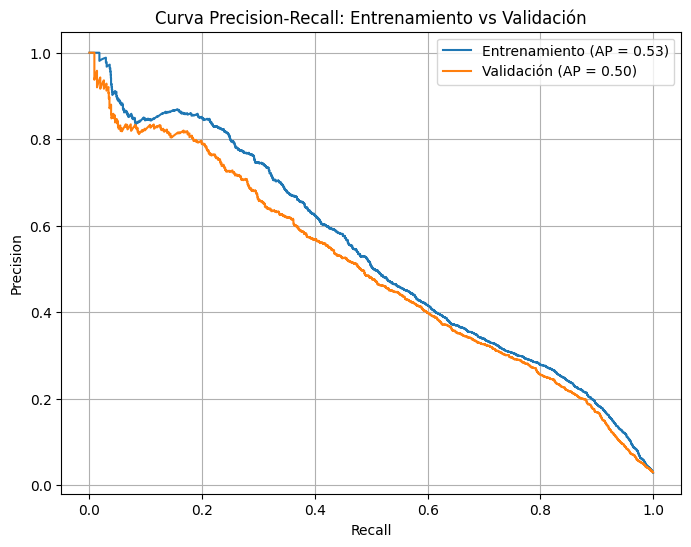

In [8]:
var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']
curva_precision_recall(df_train,pd.concat([df_test,df_val]),model_rl,variables=var_primarias,vd="vd",model_sm=False)

## 5. Pipeline ML

In [19]:
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier

# Agregar ../src al path
sys.path.append(os.path.abspath("../src"))

# Importar el archivo model.py como cp
import model as cp


numeric_transformer_ml = Pipeline(steps=[
    ('CustomNumerical', cp.CustomNumericalTransformer_ml()),
])

# Imputación para valores categóricos
categorical_transformer_ml = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

numerical_features=['date','paymentDate','expirationDate','fecha_observacion','amountFinanced','payerSalesSegment']

categorical_features=['sector']

preprocessor_ml = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_ml, numerical_features),
        ('cat', categorical_transformer_ml, categorical_features)
    ]
)

common_params = {
    'objective': 'binary',
    'n_jobs': 10,
    'force_col_wise': False,
    'verbose': -1,
   'monotone_constraints': [0, -1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}
parametros={'colsample_bytree': 0.17556707291894588,
 'learning_rate': 0.0072177803845829246,
 'max_depth': 2,
 'min_child_samples': 42,
 'min_child_weight': 0.8177278441034919,
 'min_split_gain': 0.14989937674087328,
 'n_estimators': 419,
 'num_leaves': 150,
 'reg_alpha': 0.6655783840621714,
 'reg_lambda': 0.42662540871182264,
 'subsample': 0.5574290500799713,
 'subsample_freq': 3}

# Construir el pipeline completo
model_ml = Pipeline(steps=[
    ('preprocessor', preprocessor_ml),
    ('classifier', LGBMClassifier(**common_params, **parametros))  # Sustituye por el modelo que prefieras
])

var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']

# Entrenar el pipeline
model_ml.fit(df_train[df_train["vd"].isin([0,1])][var_primarias],
           df_train[df_train["vd"].isin([0,1])]['vd'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('CustomNumerical',
                                                                   CustomNumericalTransformer_ml())]),
                                                  ['date', 'paymentDate',
                                                   'expirationDate',
                                                   'fecha_observacion',
                                                   'amountFinanced',
                                                   'payerSalesSegment']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sector'])])),
                ('classifier',
                 LGBMCla...
                                max_depth=2, min_child_samples=42,
                                min_child_weight=0.8177278441034919,
                                min_split_gain=0.14989937674087328,
                                monotone_constraints=[0, -1, 1, 1, 1, 0, 0, 0,
                                                      0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                      0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                      0, 0, 0, 0, ...],
                                n_estimators=419, n_jobs=10, num_leaves=150,
                                objective='binary',
                                reg_alpha=0.6655783840621714,
                                reg_lambda=0.42662540871182264,
                                subsample=0.5574290500799713, subsample_freq=3,
                                verbose=-1))])

In [20]:
import joblib


joblib.dump(model_ml, models_dir+'modelo_entrenado_ML.pkl')

print("El modelo se ha guardado como 'modelo_entrenado_ML.pkl'")

El modelo se ha guardado como 'modelo_entrenado_ML.pkl'


In [9]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

# Importar el archivo model.py como cp
import model as cp

model_ml=joblib.load(models_dir+'modelo_entrenado_ML.pkl')
model_ml

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('CustomNumerical',
                                                                   CustomNumericalTransformer_ml())]),
                                                  ['date', 'paymentDate',
                                                   'expirationDate',
                                                   'fecha_observacion',
                                                   'amountFinanced',
                                                   'payerSalesSegment']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sector'])])),
                ('classifier',
                 LGBMCla...
                                max_depth=2, min_child_samples=42,
                                min_child_weight=0.8177278441034919,
                                min_split_gain=0.14989937674087328,
                                monotone_constraints=[0, -1, 1, 1, 1, 0, 0, 0,
                                                      0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                      0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                      0, 0, 0, 0, ...],
                                n_estimators=419, n_jobs=10, num_leaves=150,
                                objective='binary',
                                reg_alpha=0.6655783840621714,
                                reg_lambda=0.42662540871182264,
                                subsample=0.5574290500799713, subsample_freq=3,
                                verbose=-1))])

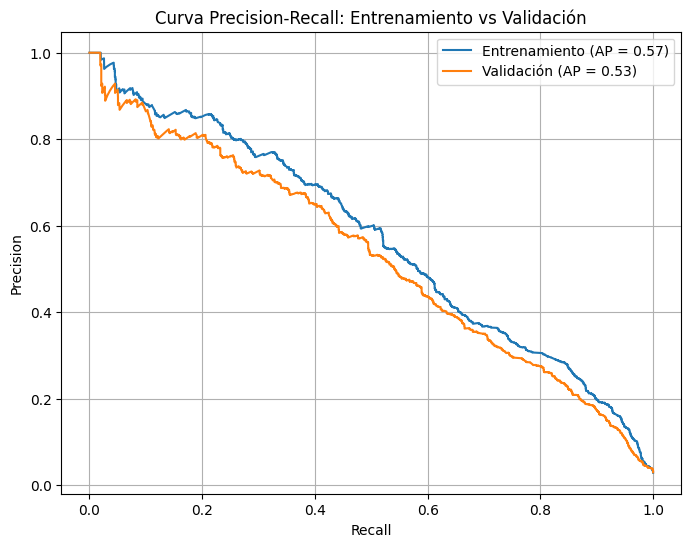

In [10]:
var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']
curva_precision_recall(df_train,pd.concat([df_test,df_val]),model_ml,variables=var_primarias,vd="vd",model_sm=False)

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def curva_roc(dev,val,modelo,variables=[],vd="vd",model_sm=True):
    
    y_train=dev[dev[vd].isin([0,1])][vd]
    y_valid=val[val[vd].isin([0,1])][vd]

    if model_sm:
        X_dev=sm.add_constant(dev[dev[vd].isin([0,1])][variables], prepend=True)
        X_val=sm.add_constant(val[val[vd].isin([0,1])][variables], prepend=True)

        y_train_scores=modelo.predict(exog = X_dev)
        y_valid_scores=modelo.predict(exog = X_val)
    else:

        y_train_scores=modelo.predict_proba(dev[dev[vd].isin([0,1])][variables])[:,1]
        y_valid_scores=modelo.predict_proba(val[val[vd].isin([0,1])][variables])[:,1]

    # Calcular la curva ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
    roc_auc_train = roc_auc_score(y_train, y_train_scores)

    # Curva ROC para validación
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_scores)
    roc_auc_valid = roc_auc_score(y_valid, y_valid_scores)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Entrenamiento (AUC = {roc_auc_train:.2f})")
    plt.plot(fpr_valid, tpr_valid, label=f"Validación (AUC = {roc_auc_valid:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Adivinanza Aleatoria")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC: Entrenamiento vs Validación")
    plt.legend()
    plt.grid()
    plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
def curva_precision_recall(dev,val,modelo,variables=[],vd="vd",model_sm=True):
    
    y_train=dev[dev[vd].isin([0,1])][vd]
    y_valid=val[val[vd].isin([0,1])][vd]

    if model_sm:

        X_dev=sm.add_constant(dev[dev[vd].isin([0,1])][variables], prepend=True)
        X_val=sm.add_constant(val[val[vd].isin([0,1])][variables], prepend=True)

        y_train_scores=modelo.predict(exog = X_dev)
        y_valid_scores=modelo.predict(exog = X_val)
    else:

        y_train_scores=modelo.predict_proba(dev[dev[vd].isin([0,1])][variables])[:,1]
        y_valid_scores=modelo.predict_proba(val[val[vd].isin([0,1])][variables])[:,1]


    # Calcular la curva ROC
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    ap_train = average_precision_score(y_train, y_train_scores)

    # Curva Precision-Recall para validación
    precision_valid, recall_valid, _ = precision_recall_curve(y_valid, y_valid_scores)
    ap_valid = average_precision_score(y_valid, y_valid_scores)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(recall_train, precision_train, label=f"Entrenamiento (AP = {ap_train:.2f})")
    plt.plot(recall_valid, precision_valid, label=f"Validación (AP = {ap_valid:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision-Recall: Entrenamiento vs Validación")
    plt.legend()
    plt.grid()
    plt.show()    

vd='vd'
score="score"
desciones='payerSalesSegment'

from sklearn.metrics import roc_curve, roc_auc_score

def tabla_performance(df,vd,score,desciones):

    df=df[df[vd].isin([0,1,2])].copy()
    df['vd']=np.where(df[vd]==2,1,df[vd])

    df = df.sort_values(by=score, ascending=True)

    df['cum_bad'] = df[vd].cumsum() / df[vd].sum()
    df['cum_good'] = (1 - df[vd]).cumsum() / (1 - df[vd]).sum()
    df['ks'] = df['cum_bad'] - df['cum_good']


    ks_value = round(df['ks'].max()*100,2)
    auc = round(roc_auc_score(df[vd], 1000-df[score])*100,2)
    gini = round((2 * auc/100 - 1)*100,2)

    print(f"ks {ks_value}",f"auc {auc}",f"gini {gini}")


    df_tmp=df.groupby([desciones]).agg(
        score_min=(score,'min'),
        score_max=(score,'max'),
        malos=(vd,'sum'),
        total=(vd,'size'),
    )
    df_tmp["bad_rate"]=df_tmp["malos"]/df_tmp["total"]
    df_tmp["malo%"]=df_tmp["malos"]/df_tmp["malos"].sum()
    df_tmp["maloCum"]=df_tmp['malos'].cumsum()

    df_tmp["total%"]=df_tmp["total"]/df_tmp["total"].sum()
    df_tmp["totalCum"]=df_tmp['total'].cumsum()
    df_tmp["totalCum%"]=df_tmp['total%'].cumsum()
    df_tmp["bad_rateCum"]=df_tmp["maloCum"]/df_tmp["totalCum"]

    return df_tmp[["score_min","score_max",'total','total%',"totalCum%",'malos',"malo%",'bad_rate','bad_rateCum']]